# Probabilidad de Adición

#### Librerias y conexión

Librerias

In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)

from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Transformación de las Variables y Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

Consulta SQL.

In [2]:
query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''

In [3]:
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset es de: {secop_I.shape[0]}\nEl número de columnas del dataset es de: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset es de: 26553
El número de columnas del dataset es de: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,...,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,...,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,...,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,...,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,...,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,...,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


#### Eliminación de columnas irrelevantes

In [4]:
# eliminación de variables con información poco relevante
secop_I_filter = secop_I.filter(items=['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                'con_adicion_pptal'])
secop_I_filter.head(5)

,tipo_de_contrato,id_grupo,cuantia_proceso,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar,con_adicion_pptal
0,suministro,E,50000000,cundinamarca,330,50000000,0
1,prestacion de servicios,E,22980096902,bogota,660,53000000,0
2,prestacion de servicios,E,35998452,bogota,31,55000000,0
3,prestacion de servicios,F,16767536,bogota,170,72000000,0
4,no encontrado en hoja proceso,F,0,bogota,360,73000000,0


In [5]:
#---------- Grupo ----------
print(secop_I.groupby(['id_grupo', 'nombre_grupo'])['uid'].count().sort_values(ascending=False))

id_grupo  nombre_grupo                                       
E         productos de uso final                                 15875
F         servicios                                               4729
B         materias primas                                         2214
A         material vivo animal vegetal                            1518
D         componentes suministros                                 1241
C         maquinaria herramientas equipo industrial vehiculos      943
G         terrenos edificios estructuras vias                       33
Name: uid, dtype: int64


#### Casteo de las variables

In [6]:
# casteo de las variables
secop_I_filter['tipo_de_contrato'] = secop_I_filter['tipo_de_contrato'].astype('category')
secop_I_filter['departamento_ejecucion'] = secop_I_filter['departamento_ejecucion'].astype('category')
secop_I_filter['id_objeto_a_contratar'] = secop_I_filter['id_objeto_a_contratar'].astype('category')
secop_I_filter['cuantia_proceso'] = secop_I_filter['cuantia_proceso'].astype('int')
secop_I_filter['plazo_de_ejec_del_contrato_'] = secop_I_filter['plazo_de_ejec_del_contrato_'].astype('int')
secop_I_filter['con_adicion_pptal'] = secop_I_filter['con_adicion_pptal'].astype('int')

In [7]:
secop_I_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   tipo_de_contrato             26553 non-null  category
 1   id_grupo                     26553 non-null  object  
 2   cuantia_proceso              26553 non-null  int64   
 3   departamento_ejecucion       26553 non-null  category
 4   plazo_de_ejec_del_contrato_  26553 non-null  int64   
 5   id_objeto_a_contratar        26553 non-null  category
 6   con_adicion_pptal            26553 non-null  int64   
dtypes: category(3), int64(3), object(1)
memory usage: 911.9+ KB


In [8]:
secop_I_filter[['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                ]].head()

,tipo_de_contrato,id_grupo,cuantia_proceso,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar
0,suministro,E,50000000,cundinamarca,330,50000000
1,prestacion de servicios,E,22980096902,bogota,660,53000000
2,prestacion de servicios,E,35998452,bogota,31,55000000
3,prestacion de servicios,F,16767536,bogota,170,72000000
4,no encontrado en hoja proceso,F,0,bogota,360,73000000


#### Split de la variable dependiente de las varibales independientes

In [9]:
# conjunto de datos train
x_train = secop_I_filter.drop('con_adicion_pptal', axis=1)
y_adicion = secop_I_filter['con_adicion_pptal']

#### Preprocesamiento

In [10]:
num_col = x_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_col = x_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
num_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='median')), 
                             ('scaler', StandardScaler())])

# Transformaciones para las variables categóricas
cat_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='most_frequent')), 
                             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', num_trans, num_col),
                        ('cat', cat_trans, cat_col)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out=False
               ).set_output(transform="pandas")

secop_I_filter_prep = preprocessor.fit_transform(x_train)

In [11]:
from pickle import dump

# save the scaler
#dump(preprocessor, open('/Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tools/utils/preprocessor_adicion.pkl', 'wb'))

In [12]:
# conteo categorico
secop_I_filter_prep = pd.concat([secop_I_filter_prep, y_adicion], axis=1)
secop_I_filter_prep['con_adicion_pptal'].value_counts()

0    23756
1     2797
Name: con_adicion_pptal, dtype: int64

In [13]:
secop_I_filter_prep.head(3)

,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,...,id_objeto_a_contratar_84000000,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,con_adicion_pptal
0,0.183652,1.831428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,138.304964,4.239830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.099312,-0.350730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


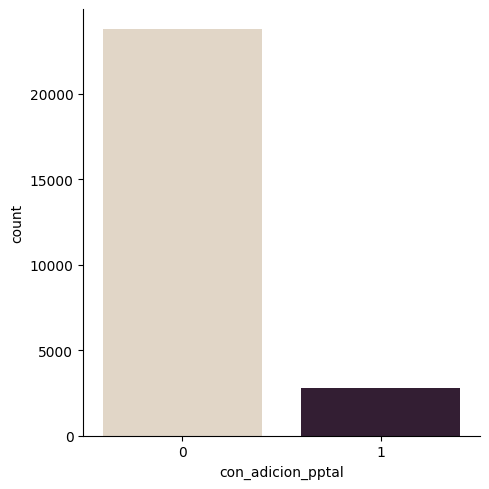

In [14]:
sns.catplot(data=secop_I_filter_prep, x="con_adicion_pptal", kind="count", palette="ch:.25")

Del análisis exploratorio se evidencio que las clases de la variable *con_adicion_pptal* se ecuentran significativamente desbalanceadas, por lo que cualquier análisis en conjunto, es decir, para identificar posibles relaciones con la variable de interés con las otras estará sesgada por dicho desbalanceo.

In [15]:
secop_I_filter_prep.head(5)

,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,...,id_objeto_a_contratar_84000000,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,con_adicion_pptal
0,0.183652,1.831428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,138.304964,4.239830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.099312,-0.350730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.016527,0.663718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.117527,2.050374,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, train que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y test para comprobar el rendimiento de los modelos que representa el 20% restante.

In [16]:
# conjunto de datos train
train_datos = secop_I_filter_prep.sample(frac=0.9, random_state=0)

# conjunto de datos test
test_datos = secop_I_filter_prep.drop(train_datos.index)

In [17]:
train_datos

,cuantia_proceso,plazo_de_ejec_del_contrato_,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,...,id_objeto_a_contratar_84000000,id_objeto_a_contratar_85000000,id_objeto_a_contratar_86000000,id_objeto_a_contratar_90000000,id_objeto_a_contratar_91000000,id_objeto_a_contratar_92000000,id_objeto_a_contratar_93000000,id_objeto_a_contratar_94000000,id_objeto_a_contratar_95000000,con_adicion_pptal
23698,-0.103451,-0.576974,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
19086,-0.039885,0.736700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
20272,-0.082886,1.393537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
992,-0.106456,-0.503992,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3302,-0.115720,-0.467501,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,-0.108251,-0.248556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13737,-0.010097,-0.562378,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5958,-0.075362,1.612482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
997,-0.110950,-0.547781,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
train_datos.reset_index(inplace=True, drop=True)
test_datos.reset_index(inplace=True, drop=True)
print('Datos para el modelo: ' + str(train_datos.shape))
print('Datos para las predicciones: ' + str(test_datos.shape))

Datos para el modelo: (23898, 108)
Datos para las predicciones: (2655, 108)


#### Implementacion de los modelos
*(Tomado de la documentacion de PyCaret)*

Paso seguido se define el entorno de PyCaret con los datos de entrenamiento, esto hará que cada vez que se llame a un modelo a entrenar se escojan dichos datos para entrenar. Además este proceso también preprocesa los datos automáticamente de manera que sea más fácil aplicar los modelos estadísticos. Asimismo, se valida que tipo de modelos ofrece la libreria PyCaret.

##### Modelos de Clasificación

In [19]:
# definicion del modelo
from pycaret.classification import *
s = setup(train_datos,
            target='con_adicion_pptal',
            transformation = True,
            train_size=0.9,
            pca=True,
            session_id=123)
models()

,Description,Value
0,Session id,123
1,Target,con_adicion_pptal
2,Target type,Binary
3,Original data shape,"(23898, 108)"
4,Transformed data shape,"(23898, 108)"
5,Transformed train set shape,"(21508, 108)"
6,Transformed test set shape,"(2390, 108)"
7,Numeric features,107
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### Se escoge el modelo con un recall y AUC alto

In [21]:
# compare models
best = compare_models(probability_threshold=0.25)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.8941,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1590
ridge,Ridge Classifier,0.8941,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1520
dummy,Dummy Classifier,0.8941,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1500
lr,Logistic Regression,0.8776,0.7178,0.1278,0.3138,0.1813,0.1275,0.1430,0.1670
gbc,Gradient Boosting Classifier,0.8728,0.7844,0.3092,0.3779,0.3398,0.2703,0.2721,0.1410
catboost,CatBoost Classifier,0.8681,0.8119,0.4058,0.3842,0.3945,0.3206,0.3209,0.1510
lightgbm,Light Gradient Boosting Machine,0.8633,0.8076,0.4071,0.3681,0.3864,0.3097,0.3103,0.1510
xgboost,Extreme Gradient Boosting,0.8603,0.8042,0.4001,0.3577,0.3774,0.2991,0.2998,0.1600
lda,Linear Discriminant Analysis,0.8586,0.7461,0.2565,0.3037,0.2777,0.2000,0.2011,0.1450
knn,K Neighbors Classifier,0.8537,0.7170,0.3786,0.3327,0.3539,0.2719,0.2727,0.2360


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [22]:
model_final = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8754,0.7530,0.1938,0.3411,0.2472,0.1848,0.1937
1,0.8884,0.7523,0.2500,0.4524,0.3220,0.2667,0.2807
2,0.8735,0.7427,0.2061,0.3406,0.2568,0.1923,0.1995
3,0.8810,0.7606,0.2237,0.3923,0.2849,0.2253,0.2359
4,0.8856,0.7665,0.2368,0.4286,0.3051,0.2484,0.2614
5,0.8815,0.7591,0.2149,0.3920,0.2776,0.2190,0.2308
6,0.8787,0.7680,0.2412,0.3846,0.2965,0.2339,0.2415
7,0.8894,0.7861,0.2675,0.4621,0.3389,0.2832,0.2958
8,0.8814,0.7615,0.1630,0.3627,0.2249,0.1706,0.1868


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
r2_tuned = tune_model(model_final, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7062,0.7692,0.6784,0.2160,0.3277,0.1995,0.2532
1,0.7173,0.7757,0.6667,0.2222,0.3333,0.2073,0.2578
2,0.7122,0.7891,0.6930,0.2235,0.3380,0.2116,0.2670
3,0.7248,0.7792,0.6272,0.2200,0.3257,0.2002,0.2437
4,0.7062,0.7627,0.6711,0.2155,0.3262,0.1974,0.2497
5,0.7257,0.7739,0.6404,0.2232,0.3311,0.2063,0.2517
6,0.7122,0.7610,0.6798,0.2211,0.3337,0.2068,0.2600
7,0.7229,0.7879,0.7018,0.2326,0.3493,0.2261,0.2819
8,0.7437,0.7881,0.6960,0.2469,0.3645,0.2471,0.2993


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [24]:
#test_datos
#secop_I_filter.drop(train_datos.index).loc[secop_I_filter["con_adicion_pptal"]==1]


In [27]:
result = predict_model(r2_tuned, data=test_datos)
#result[result["prediction_label"]==1]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7134,0.7673,0.6742,0.2108,0.3211,0.1983,0.2523


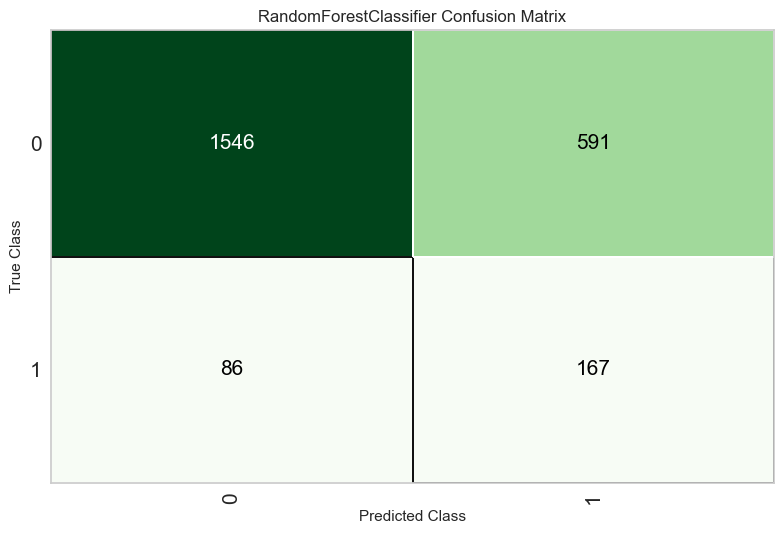

In [28]:
# plot confusion matrix
plot_model(r2_tuned, plot='confusion_matrix')

In [30]:
save_model(model_final, model_name = '/Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/RFClassifier_adicion')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/cy/6g84nnc90d3blx29rvlncq2c0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['cuantia_proceso',
                                              'plazo_de_ejec_del_contrato_',
                                              'tipo_de_contrato_acuerdo marco',
                                              'tipo_de_contrato_arrendamiento',
                                              'tipo_de_contrato_comodato',
                                              'tipo_de_contrato_compraventa',
                                              'tipo_de_contrat...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=None, max_

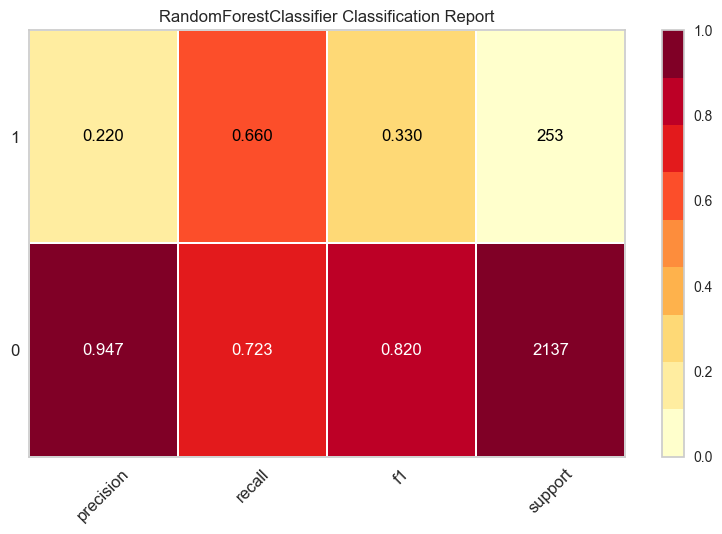

In [31]:
# plot confusion matrix
plot_model(r2_tuned, plot='class_report')

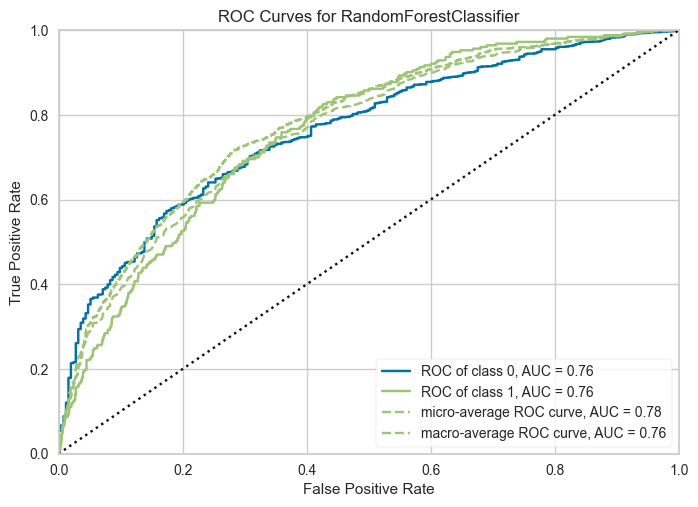

In [33]:
# plot AUC
plot_model(r2_tuned, plot = 'auc')